In [488]:
library(Quandl)
library(quantmod)
library(timeSeries)
library(corrplot)
library(ggplot2)
library(urca)
library(PerformanceAnalytics)
library(tseries)

In [489]:
Quandl.api_key('jXs6umTNNaQMp2G2sYm8')

In [490]:
pairs = c(
    "ETHBTC",
    "LTCBTC",
    "XRPBTC",
    "XMRBTC",
    "ZECBTC",
    "DSHBTC"
)
startDate = "2018-01-01"
endDate = "2018-12-01"

In [491]:
pairsDataList = list()
pairsDataListXts = list()

for(i in 1:length(pairs)){
    pair = pairs[i]
    bifinexPair = paste("BITFINEX/", pair, sep = "")
    pairData = Quandl(bifinexPair, start_date=startDate, end_date=endDate)
    assign(pair, pairData)
    pairDataXts = as.xts(pairData, order.by = pairData$Date, x=pairData$Last)
    pairsDataList[[i]] = pairData
    pairsDataListXts[[i]] = pairDataXts
}

In [492]:
ZECBTCXTS = pairsDataListXts[[5]]
DSHBTCXTS = pairsDataListXts[[6]]
PAIRXTS = merge(ZECBTCXTS, DSHBTCXTS, join = "left")
names(PAIRXTS) = c("ZECBTC", "DSHBTC")

In [493]:
jotest=ca.jo(PAIRXTS, type="trace", K=2, ecdet="none", spec="longrun")
summary(jotest)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend 

Eigenvalues (lambda):
[1] 0.040592920 0.009793911

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 1 |  3.20  6.50  8.18 11.65
r = 0  | 16.67 15.66 17.95 23.52

Eigenvectors, normalised to first column:
(These are the cointegration relations)

           ZECBTC.l2 DSHBTC.l2
ZECBTC.l2  1.0000000  1.000000
DSHBTC.l2 -0.5861501  0.224751

Weights W:
(This is the loading matrix)

            ZECBTC.l2    DSHBTC.l2
ZECBTC.d -0.063673166 -0.006547003
DSHBTC.d  0.008594671 -0.012099956


In [494]:
# Print all pairs that has r = 0 above the critical value of 17.95
R0_CRITICAL = 17.95
for(i1 in 1:length(pairsDataListXts)){
    for(i2 in 1:length(pairsDataListXts)){
        if(i1 != i2){
            PAIRXTS = merge(pairsDataListXts[[i1]], pairsDataListXts[[i2]], join = "left")
            jotest=ca.jo(PAIRXTS, type="trace", K=2, ecdet="none", spec="longrun")
            if(jotest@teststat[2] >= R0_CRITICAL){
                print(paste(pairs[i1], pairs[i2]))
                print(jotest@teststat)
            }
        }
    }
}

[1] "ETHBTC XRPBTC"
[1]  2.615824 32.276714
[1] "ETHBTC DSHBTC"
[1]  1.711873 25.922373
[1] "XRPBTC ETHBTC"
[1]  2.615824 32.276714
[1] "XRPBTC ZECBTC"
[1]  4.433185 19.632115
[1] "ZECBTC XRPBTC"
[1]  4.433185 19.632115
[1] "DSHBTC ETHBTC"
[1]  1.711873 25.922373


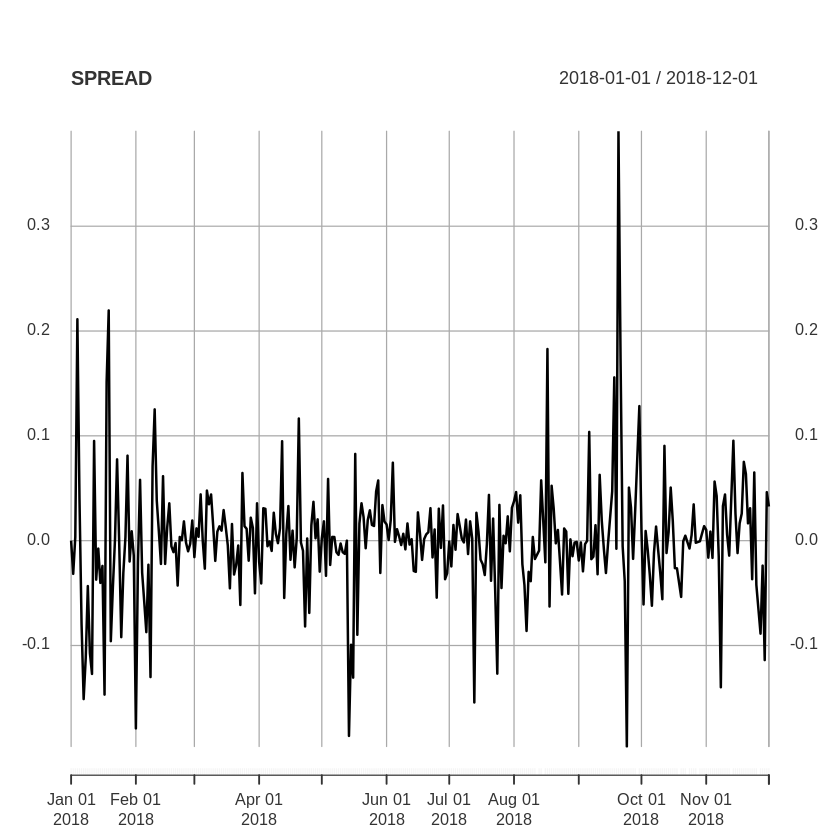

In [495]:
# Trying for XRPBTC(3) / ZECBTC(5)
XRPXTS_DR = dailyReturn(pairsDataListXts[[3]])
ZECBTS_DR = dailyReturn(pairsDataListXts[[5]])
SPREAD = XRPXTS_DR - ZECBTS_DR
plot(SPREAD)

In [496]:
adf.test(SPREAD)

Warning message in adf.test(SPREAD):
“p-value smaller than printed p-value”


	Augmented Dickey-Fuller Test

data:  SPREAD
Dickey-Fuller = -7.0876, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


In [497]:
# Function to calculate spead based on z-score
Z_SPREAD = function(x){
    return (x * sd(SPREAD) + mean(SPREAD))
}

In [498]:
# Enter when current return spread is 3 standard deviation away
# and exit when it's 1 standard deviation away
ENTER_RET = Z_SPREAD(3)
EXIT_RET = Z_SPREAD(1)

# 0 = neutral, 1 = long, -1 = short
signal = list()
signal[1] = 0
for(i in 2:nrow(SPREAD)){
    prevPosition = signal[i-1]
    ret = SPREAD[[i]]
    
    if(ret <= (-ENTER_RET)){
        # Enter long if return <= -ENTER_RET
        signal[i] = 1
    }else if(ret >= ENTER_RET){
        # Enter short if return >= ENTER_RET
        signal[i] = -1
    }else if(prevPosition == 1 && ret >= EXIT_RET){
        # Exit long if return >= EXIT_RET
        signal[i] = 0
    }else if(prevPosition == -1 && ret <= (-EXIT_RET)){
        # Exit short if return <= EXIT_RET
        signal[i] = 0
    }else{
        signal[i] = prevPosition
    }
}

RES = merge(SPREAD, signal)
# plot(RES)

# trade_return = SPREAD$daily.returns * lag(signal)
#     SPREAD$daily.returns
RES$tradeReturn = RES$daily.returns * lag(RES$signal)
head(RES)

           daily.returns signal tradeReturn
2018-01-01   0.000000000      0          NA
2018-01-02  -0.031663573      0  0.00000000
2018-01-03   0.003453594      0  0.00000000
2018-01-04   0.211254927     -1  0.00000000
2018-01-05   0.040585192     -1 -0.04058519
2018-01-06  -0.079457605      0  0.07945761

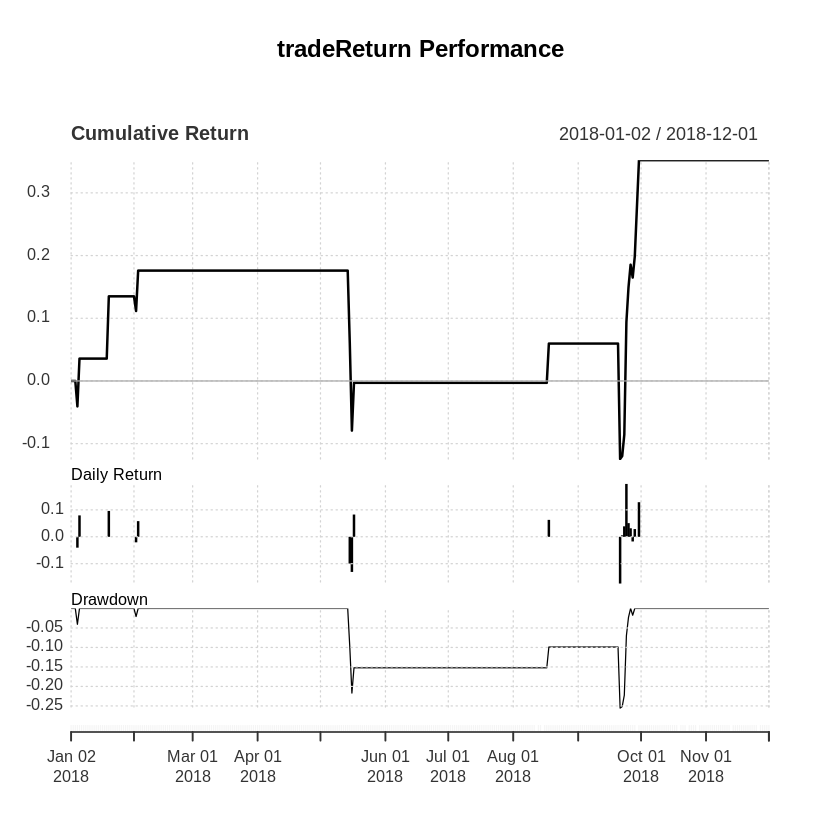

In [499]:
charts.PerformanceSummary(na.approx(RES$tradeReturn))

In [500]:
Return.cumulative(RES$tradeReturn)
Return.annualized(RES$tradeReturn)
maxDrawdown(RES$tradeReturn)
SharpeRatio(RES$tradeReturn, Rf = 0, p=0.95, FUN = "StdDev")
SharpeRatio.annualized(RES$tradeReturn, Rf = 0)

,tradeReturn
Cumulative Return,0.352222


,tradeReturn
Annualized Return,0.2627021


[1] 0.2555311

,tradeReturn
"StdDev Sharpe (Rf=0%, p=95%):",0.05379146


,tradeReturn
Annualized Sharpe Ratio (Rf=0%),0.7710583


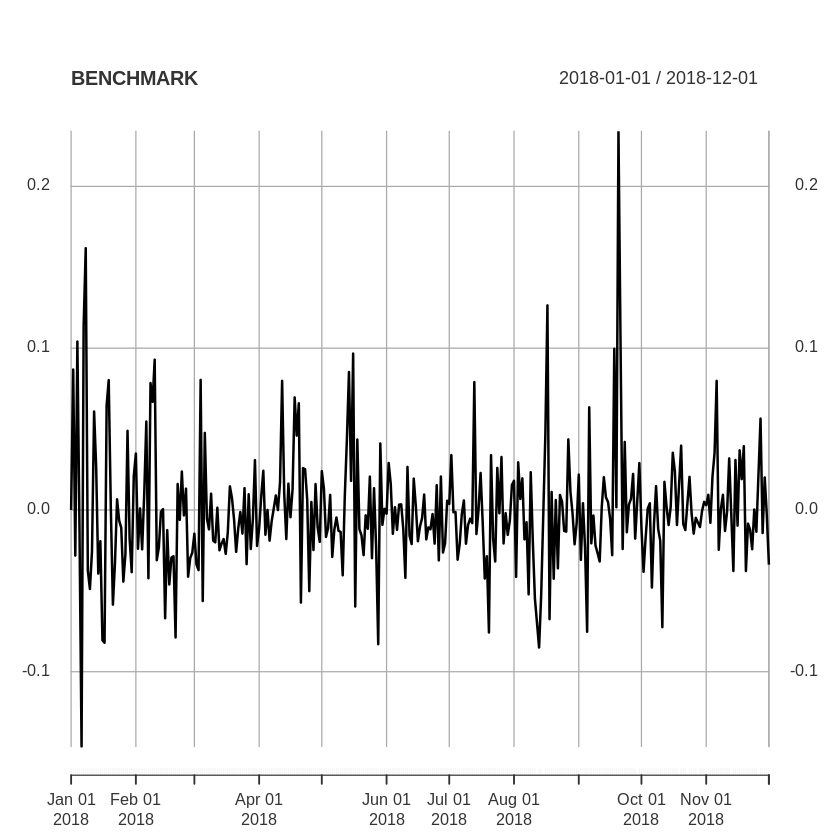

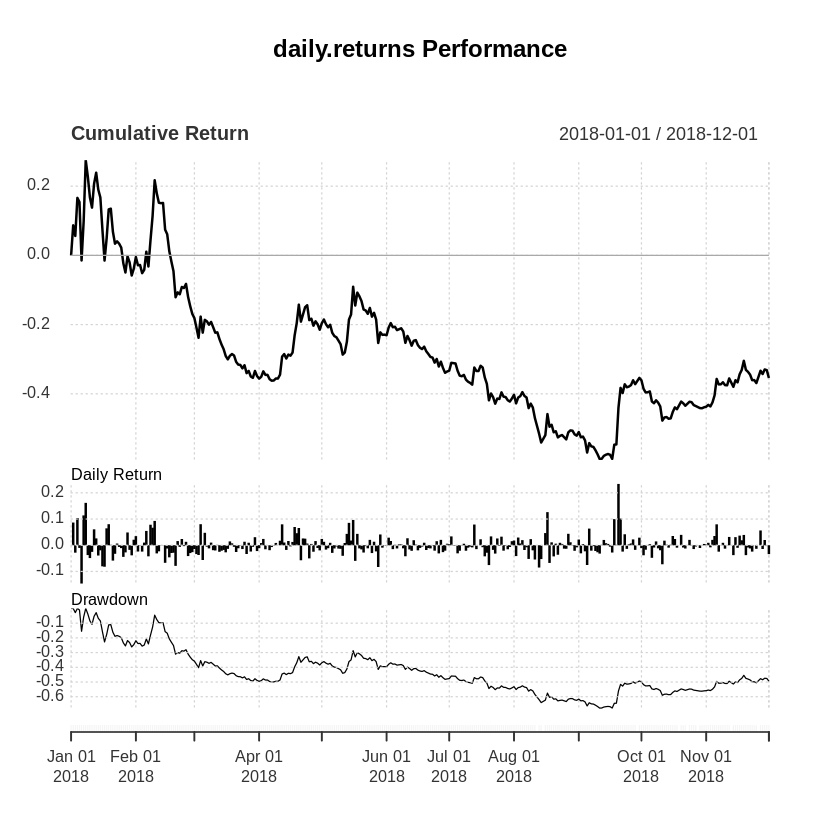

In [501]:
# Adding benchmark
BENCHMARK = (XRPXTS_DR + ZECBTS_DR) / 2
plot(BENCHMARK)
charts.PerformanceSummary(na.approx(BENCHMARK))

In [502]:
Return.cumulative(BENCHMARK)
Return.annualized(BENCHMARK)
maxDrawdown(BENCHMARK)
SharpeRatio(BENCHMARK, Rf = 0, p=0.95, FUN = "StdDev")
SharpeRatio.annualized(BENCHMARK, Rf = 0)

,daily.returns
Cumulative Return,-0.3542302


,daily.returns
Annualized Return,-0.2860992


[1] 0.6771995

,daily.returns
"StdDev Sharpe (Rf=0%, p=95%):",-0.01609935


,daily.returns
Annualized Sharpe Ratio (Rf=0%),-0.4688807


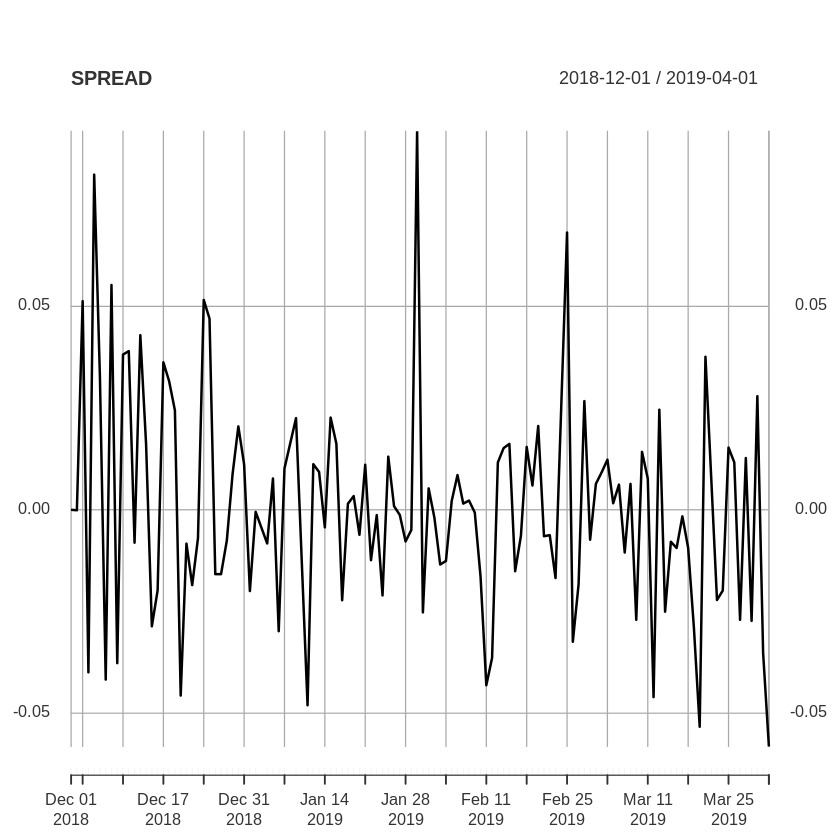

In [503]:
# Applying to out-of-sample data
pairs = c(
    "XRPBTC",
    "ZECBTC"
)
startDate = "2018-12-01"
endDate = "2019-04-01"
pairsDataListXts = list()

for(i in 1:length(pairs)){
    pair = pairs[i]
    bifinexPair = paste("BITFINEX/", pair, sep = "")
    pairData = Quandl(bifinexPair, start_date=startDate, end_date=endDate)
    assign(pair, pairData)
    pairDataXts = as.xts(pairData, order.by = pairData$Date, x=pairData$Last)
    pairsDataListXts[[i]] = pairDataXts
}

XRPXTS_DR = dailyReturn(pairsDataListXts[[1]])
ZECBTS_DR = dailyReturn(pairsDataListXts[[2]])
SPREAD = XRPXTS_DR - ZECBTS_DR
plot(SPREAD)

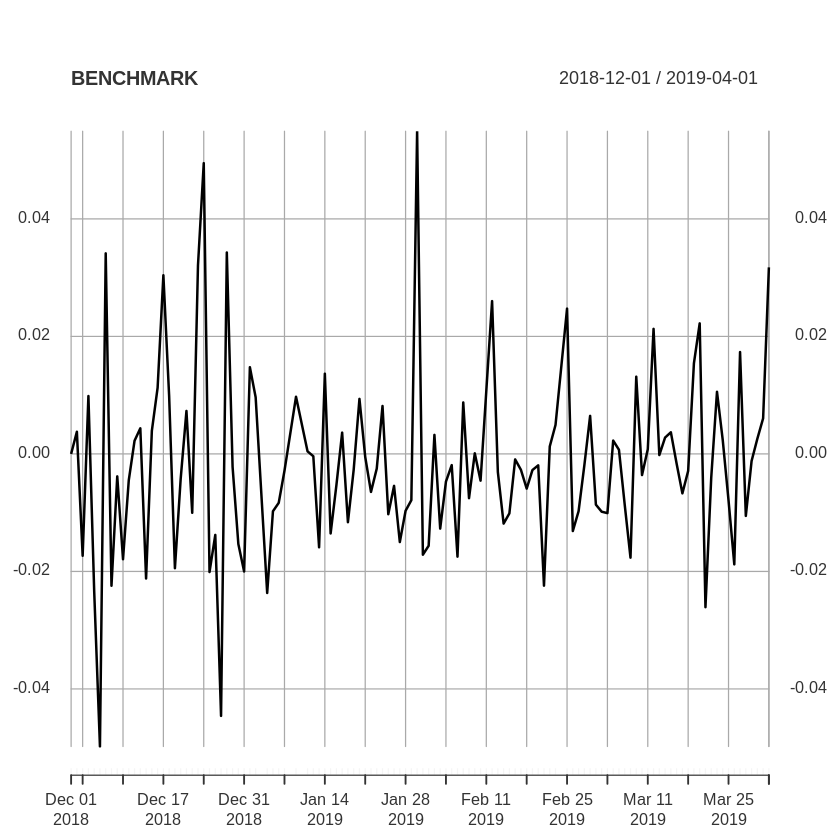

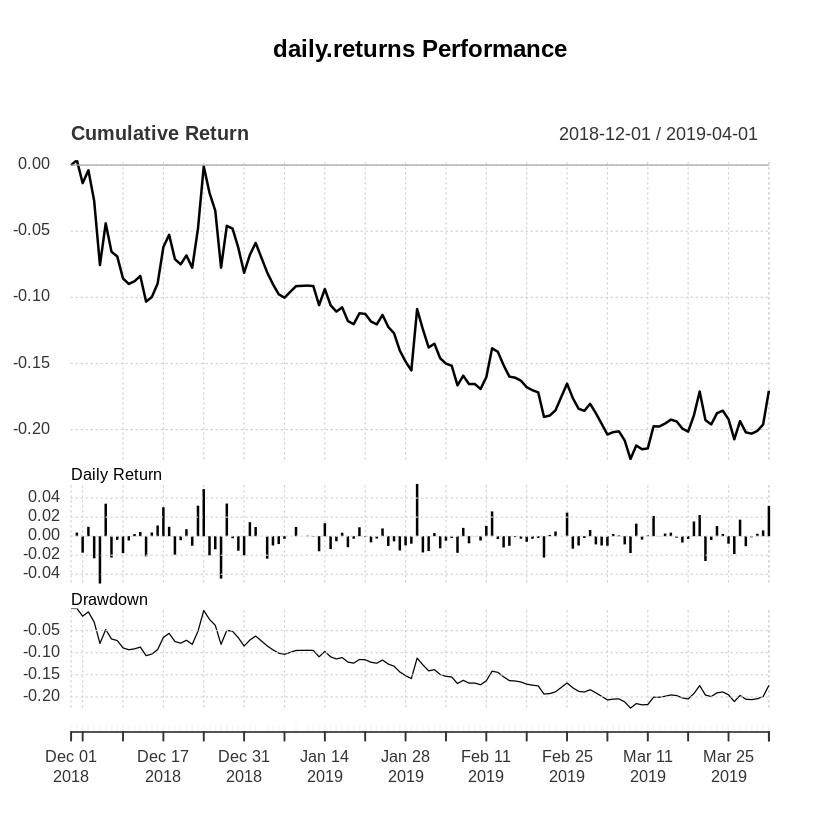

In [504]:
# Adding benchmark
BENCHMARK = (XRPXTS_DR + ZECBTS_DR) / 2
plot(BENCHMARK)
charts.PerformanceSummary(na.approx(BENCHMARK))

In [505]:
# Enter when current return spread is 3 standard deviation away
# and exit when it's 1 standard deviation away
ENTER_RET = Z_SPREAD(3)
EXIT_RET = Z_SPREAD(1)

# 0 = neutral, 1 = long, -1 = short
signal = list()
signal[1] = 0
for(i in 2:nrow(SPREAD)){
    prevPosition = signal[i-1]
    ret = SPREAD[[i]]
    
    if(ret <= (-ENTER_RET)){
        # Enter long if return <= -ENTER_RET
        signal[i] = 1
    }else if(ret >= ENTER_RET){
        # Enter short if return >= ENTER_RET
        signal[i] = -1
    }else if(prevPosition == 1 && ret >= EXIT_RET){
        # Exit long if return >= EXIT_RET
        signal[i] = 0
    }else if(prevPosition == -1 && ret <= (-EXIT_RET)){
        # Exit short if return <= EXIT_RET
        signal[i] = 0
    }else{
        signal[i] = prevPosition
    }
}

RES = merge(SPREAD, signal)
RES$tradeReturn = RES$daily.returns * lag(RES$signal)

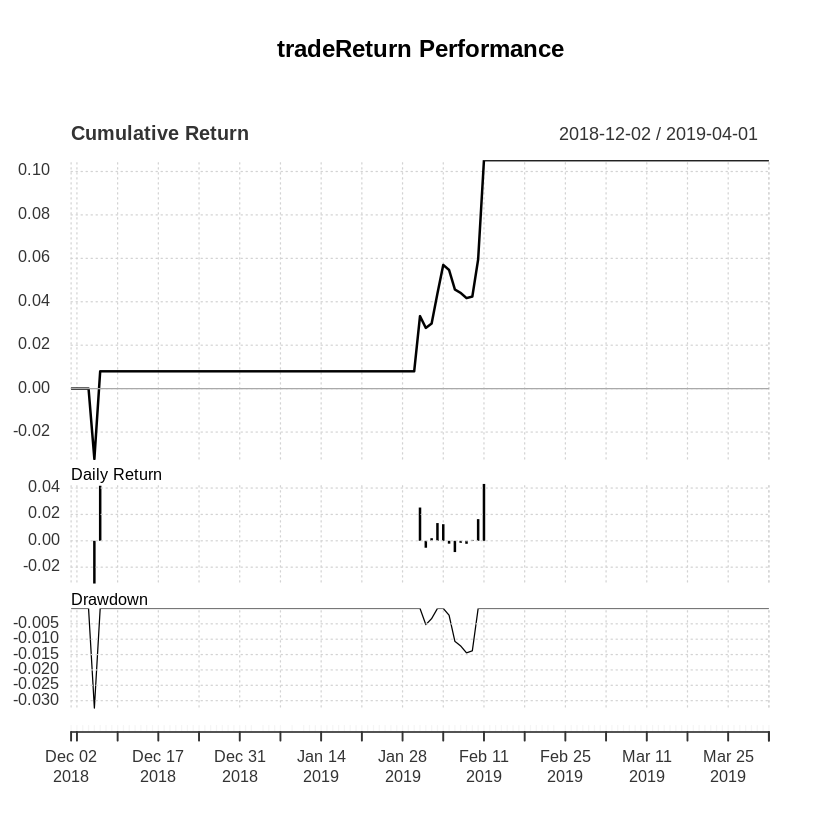

In [506]:
charts.PerformanceSummary(na.approx(RES$tradeReturn))

In [507]:
Return.cumulative(RES$tradeReturn)
Return.annualized(RES$tradeReturn)
maxDrawdown(RES$tradeReturn)
SharpeRatio(RES$tradeReturn, Rf = 0, p=0.95, FUN = "StdDev")
SharpeRatio.annualized(RES$tradeReturn, Rf = 0)

,tradeReturn
Cumulative Return,0.1052364


,tradeReturn
Annualized Return,0.2404972


[1] 0.03241391

,tradeReturn
"StdDev Sharpe (Rf=0%, p=95%):",0.1232066


,tradeReturn
Annualized Sharpe Ratio (Rf=0%),2.119837


In [508]:
SharpeRatio(RES$tradeReturn, Rf = 0.02, p=0.95, FUN = "StdDev")
SharpeRatio.annualized(RES$tradeReturn, Rf = 0.02)

,tradeReturn
"StdDev Sharpe (Rf=2%, p=95%):",-2.675277


,tradeReturn
Annualized Sharpe Ratio (Rf=504%),-8.746845


## References
https://towardsdatascience.com/pairs-trading-with-cryptocurrencies-e79b4a00b015
https://analyticsprofile.com/algo-trading/pair-trading-part-1-code-distance-based-pair-trading-strategy-in-r/